In [1]:
import time
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['font.family'] = ['sans-serif']
import seaborn as sns
import numpy as np

import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns',100)#显示最大列数

# 读取数据

In [2]:
data_path = '../data/'
train_data = pd.read_csv(data_path + 'train_dataset.csv')
test_data = pd.read_csv(data_path + 'test_dataset.csv')
sample_sub = pd.read_csv(data_path + 'submit_example.csv')

# 查看特征名称

In [3]:
train_data.columns

Index(['用户编码', '用户实名制是否通过核实', '用户年龄', '是否大学生客户', '是否黑名单客户', '是否4G不健康客户',
       '用户网龄（月）', '用户最近一次缴费距今时长（月）', '缴费用户最近一次缴费金额（元）', '用户近6个月平均消费值（元）',
       '用户账单当月总费用（元）', '用户当月账户余额（元）', '缴费用户当前是否欠费缴费', '用户话费敏感度', '当月通话交往圈人数',
       '是否经常逛商场的人', '近三个月月均商场出现次数', '当月是否逛过福州仓山万达', '当月是否到过福州山姆会员店', '当月是否看电影',
       '当月是否景点游览', '当月是否体育场馆消费', '当月网购类应用使用次数', '当月物流快递类应用使用次数',
       '当月金融理财类应用使用总次数', '当月视频播放类应用使用次数', '当月飞机类应用使用次数', '当月火车类应用使用次数',
       '当月旅游资讯类应用使用次数', '信用分'],
      dtype='object')


# 查看是否存在缺失值，以及数据量


train_data.info()

# 特征工程

In [5]:
##top up amount, 充值金额是整数，和小数，应该对应不同的充值途径？
def produce_offline_feature(train_data):
    train_data['不同充值途径']=0
    train_data['不同充值途径'][(train_data['缴费用户最近一次缴费金额（元）']%10==0)&train_data['缴费用户最近一次缴费金额（元）']!=0]=1
    return train_data

train_data=produce_offline_feature(train_data)
test_data=produce_offline_feature(test_data)

/root/userfolder/anac/root/userfolder/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [6]:
##看importance，当月话费 和最近半年平均话费都很高，算一下当月/半年 -->稳定性
def produce_fee_rate(train_data):
    train_data['当前费用稳定性']=train_data['用户账单当月总费用（元）']/(train_data['用户近6个月平均消费值（元）']+1)
    
    ##当月话费/当月账户余额
    train_data['用户余额比例']=train_data['用户账单当月总费用（元）']/(train_data['用户当月账户余额（元）']+1)
    return train_data

train_data=produce_offline_feature(train_data)
test_data=produce_offline_feature(test_data)

/root/userfolder/anac/root/userfolder/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
#获取特征
def get_features(data):
    data.loc[data['用户年龄']==0,'用户年龄']=data['用户年龄'].mode()
    data['缴费金额是否能覆盖当月账单']=data['缴费用户最近一次缴费金额（元）']-data['用户账单当月总费用（元）']
    data['最近一次缴费是否超过平均消费额']=data['缴费用户最近一次缴费金额（元）']-data['用户近6个月平均消费值（元）']
    data['当月账单是否超过平均消费额']=data['用户账单当月总费用（元）']-data['用户近6个月平均消费值（元）']
    
    #映射年龄
    def map_age(x):
        if x<=18:
            return 1
        elif x<=30:
            return 2
        elif x<=35:
            return 3
        elif x<=45:
            return 4
        else:
            return 5
    data['是否大学生_黑名单']=data['是否大学生客户']+data['是否黑名单客户']
    data['是否去过高档商场']=data['当月是否到过福州山姆会员店']+data['当月是否逛过福州仓山万达']
    data['是否去过高档商场']=data['是否去过高档商场'].map(lambda x:1 if x>=1 else 0)
    data['是否_商场_电影']=data['是否去过高档商场']*data['当月是否看电影']
    data['是否_商场_体育馆']=data['是否去过高档商场']*data['当月是否体育场馆消费']
    data['是否_商场_旅游']=data['是否去过高档商场']*data['当月是否景点游览']
    data['是否_电影_体育馆']=data['当月是否看电影']*data['当月是否体育场馆消费']
    data['是否_电影_旅游']=data['当月是否看电影']*data['当月是否景点游览']
    data['是否_旅游_体育馆']=data['当月是否景点游览']*data['当月是否体育场馆消费']
    
    data['是否_商场_旅游_体育馆']=data['是否去过高档商场']*data['当月是否景点游览']*data['当月是否体育场馆消费']
    data['是否_商场_电影_体育馆']=data['是否去过高档商场']*data['当月是否看电影']*data['当月是否体育场馆消费']
    data['是否_商场_电影_旅游']=data['是否去过高档商场']*data['当月是否看电影']*data['当月是否景点游览']
    data['是否_体育馆_电影_旅游']=data['当月是否体育场馆消费']*data['当月是否看电影']*data['当月是否景点游览']
    
    data['是否_商场_体育馆_电影_旅游']=data['是否去过高档商场']*data['当月是否体育场馆消费']*data['当月是否看电影']*data['当月是否景点游览']
    
    discretize_features=['交通类应用使用次数','当月物流快递类应用使用次数','当月飞机类应用使用次数','当月火车类应用使用次数','当月旅游资讯类应用使用次数']
    data['交通类应用使用次数']=data['当月飞机类应用使用次数']+data['当月火车类应用使用次数']
    
    data['6个月平均占比总费用']=data['用户近6个月平均消费值（元）']/data['用户账单当月总费用（元）']+1
    
    
    def map_discretize(x):
        if x==0:
            return 0
        elif x<=5:
            return 1
        elif x<=15:
            return 2
        elif x<=50:
            return 3
        elif x<=100:
            return 4
        else:
            return 5
        
    for col in discretize_features[:]:
        data[col]=data[col].map(lambda x:map_discretize(x))
    
    return data

train_data=get_features(train_data)
test_data=get_features(test_data)


In [8]:
def base_process(data):
    transform_value_feature=['用户年龄','用户网龄（月）','当月通话交往圈人数','近三个月月均商场出现次数','当月网购类应用使用次数','当月物流快递类应用使用次数'
                            ,'当月金融理财类应用使用总次数','当月视频播放类应用使用次数','当月飞机类应用使用次数','当月火车类应用使用次数','当月旅游资讯类应用使用次数']
    user_fea=['缴费用户最近一次缴费金额（元）','用户近6个月平均消费值（元）','用户账单当月总费用（元）','用户当月账户余额（元）']
    log_features=['当月网购类应用使用次数','当月金融理财类应用使用总次数','当月物流快递类应用使用次数','当月视频播放类应用使用次数']
    
    #处理离散点
    for col in transform_value_feature+user_fea+log_features:
        #取出最高99.9%值
        ulimit=np.percentile(train_data[col].values,99.9)
        #取出最低0.1%值
        llimit=np.percentile(train_data[col].values,0.1)
        train_data.loc[train_data[col]>ulimit,col]=ulimit
        train_data.loc[train_data[col]<llimit,col]=llimit
        
    for col in user_fea+log_features:
        data[col]=data[col].map(lambda x:np.log1p(x))
    
    return data

train_data=base_process(train_data)
test_data=base_process(test_data)

/root/userfolder/anac/root/userfolder/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


# 特征重要度显示函数

In [10]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

# 训练及预测

In [11]:
#para
params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mae',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'num_leaves': 31,
    'verbose': -1,
    'max_depth': -1,
    'reg_alpha':2.2,
    'reg_lambda':1.4,
    'nthread': 8
}

In [15]:
from sklearn.model_selection import KFold
cv_pred_all = 0
en_amount = 3

oof_lgb1=np.zeros(len(train_data))
prediction_lgb1=np.zeros(len(test_data))

for seed in range(en_amount):
    NFOLDS = 5
    train_label = train_data['信用分']
    
    kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=seed)
    kf = kfold.split(train_data, train_label)

    train_data_use = train_data.drop(['用户编码','信用分'], axis=1)
    test_data_use = test_data.drop(['用户编码'], axis=1)


    cv_pred = np.zeros(test_data.shape[0])
    valid_best_l2_all = 0

    feature_importance_df = pd.DataFrame()
    count = 0
    for i, (train_fold, validate) in enumerate(kf):
        print('fold: ',i, ' training')
        X_train, X_validate, label_train, label_validate = \
        train_data_use.iloc[train_fold, :], train_data_use.iloc[validate, :], \
        train_label[train_fold], train_label[validate]
        dtrain = lgb.Dataset(X_train, label_train)
        dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=dvalid, verbose_eval=-1,early_stopping_rounds=250)
        cv_pred += bst.predict(test_data_use, num_iteration=bst.best_iteration)
        valid_best_l2_all += bst.best_score['valid_0']['l1']
        
        oof_lgb1[validate]=bst.predict(X_validate,num_iteration=bst.best_iteration)
        prediction_lgb1+=bst.predict(test_data_use,num_iteration=bst.best_iteration)/kfold.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = list(X_train.columns)
        fold_importance_df["importance"] = bst.feature_importance(importance_type='split', iteration=bst.best_iteration)
        fold_importance_df["fold"] = count + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        count += 1

    cv_pred /= NFOLDS
    valid_best_l2_all /= NFOLDS
    
    cv_pred_all += cv_pred
cv_pred_all /= en_amount
prediction_lgb1/=en_amount
print('cv score for valid is: ', 1/(1+valid_best_l2_all))


fold:  0  training
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[3219]	valid_0's l1: 14.7349
fold:  1  training
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[3157]	valid_0's l1: 14.727
fold:  2  training
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[3882]	valid_0's l1: 14.5572
fold:  3  training
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[3999]	valid_0's l1: 14.5448
fold:  4  training
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[3685]	valid_0's l1: 14.7533
fold:  0  training
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[2878]	valid_0's l1: 14.6152
fold:  1  training
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[3032]	v

# 查看lgb训练完后特征重要度

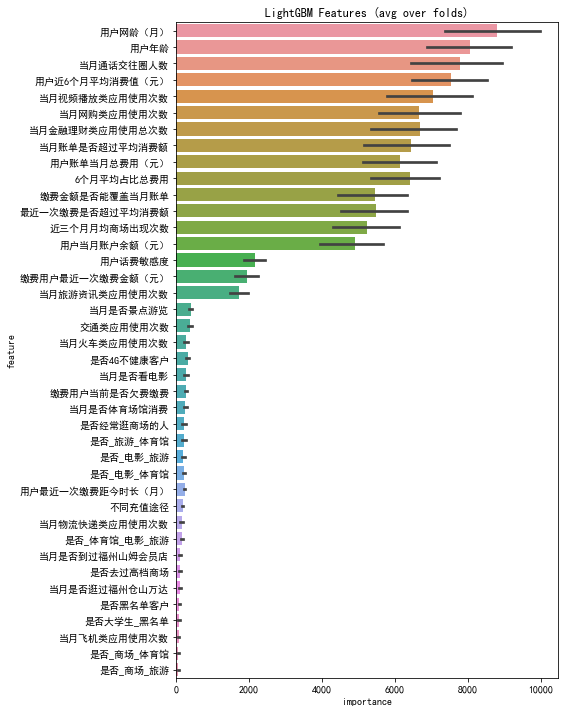

In [16]:
display_importances(feature_importance_df)

# XGB训练及预测

In [14]:

import xgboost as xgb
xgb_params={'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'nthread': 8}
from sklearn.model_selection import KFold
cv_pred_allxgb=0
en_amount=3
oof_xgb1=np.zeros(len(train_data))
prediction_xgb1=np.zeros(len(test_data))
for seed in range(en_amount):
    NFOLDS=5
    train_label=train_data['信用分']
    kfold=KFold(n_splits=NFOLDS, shuffle=True, random_state=seed+2019)
    kf=kfold.split(train_data,train_label)
    
    train_data_use = train_data.drop(['用户编码','信用分'], axis=1)
    test_data_use = test_data.drop(['用户编码'], axis=1)
    
    cv_pred = np.zeros(test_data.shape[0])
    valid_best_l2_all = 0
    
    feature_importance_df = pd.DataFrame()
    count = 0
    
    for i, (train_fold, validate) in enumerate(kf):
        print('fold: ',i, ' training')
        X_train, X_validate, label_train, label_validate = train_data_use.iloc[train_fold, :], train_data_use.iloc[validate, :], train_label[train_fold], train_label[validate]
        dtrain = xgb.DMatrix(X_train, label_train)
        dvalid = xgb.DMatrix(X_validate, label_validate)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid_data')]
        bst = xgb.train(dtrain=dtrain, num_boost_round=10000, evals=watchlist, early_stopping_rounds=100, verbose_eval=300, params=xgb_params)
        cv_pred += bst.predict(xgb.DMatrix(test_data_use), ntree_limit=bst.best_ntree_limit)
        oof_xgb1[validate]=bst.predict(xgb.DMatrix(X_validate),ntree_limit=bst.best_ntree_limit)
        prediction_xgb1+=bst.predict(xgb.DMatrix(test_data_use),ntree_limit=bst.best_ntree_limit)/kfold.n_splits
        count += 1
        
    cv_pred /= NFOLDS
    cv_pred_allxgb+=cv_pred
cv_pred_allxgb /= en_amount


fold:  0  training
[0]	train-mae:614.391	valid_data-mae:614.764
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 100 rounds.
[300]	train-mae:136.71	valid_data-mae:136.784
[600]	train-mae:31.7497	valid_data-mae:32.5511
[900]	train-mae:13.97	valid_data-mae:16.1708
[1200]	train-mae:11.8572	valid_data-mae:14.8778
[1500]	train-mae:11.1107	valid_data-mae:14.7337
[1800]	train-mae:10.5169	valid_data-mae:14.7016
[2100]	train-mae:9.99696	valid_data-mae:14.693
Stopping. Best iteration:
[2004]	train-mae:10.154	valid_data-mae:14.6922

fold:  1  training
[0]	train-mae:614.307	valid_data-mae:615.108
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 100 rounds.
[300]	train-mae:136.694	valid_data-mae:137.106
[600]	train-mae:31.7562	valid_data-mae:32.7502
[900]	train-mae:14.0004	valid_data-mae:16.1942
[1200]	train-mae:11.

[1500]	train-mae:11.1237	valid_data-mae:14.6848
[1800]	train-mae:10.518	valid_data-mae:14.6463
[2100]	train-mae:9.98012	valid_data-mae:14.637
[2400]	train-mae:9.49281	valid_data-mae:14.6327
Stopping. Best iteration:
[2385]	train-mae:9.51776	valid_data-mae:14.6324

fold:  3  training
[0]	train-mae:614.467	valid_data-mae:614.459
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 100 rounds.
[300]	train-mae:136.73	valid_data-mae:136.408
[600]	train-mae:31.7518	valid_data-mae:32.2803
[900]	train-mae:13.9581	valid_data-mae:16.0564
[1200]	train-mae:11.8405	valid_data-mae:14.793
[1500]	train-mae:11.0877	valid_data-mae:14.6669
[1800]	train-mae:10.4759	valid_data-mae:14.6427
[2100]	train-mae:9.95345	valid_data-mae:14.637
Stopping. Best iteration:
[2044]	train-mae:10.0518	valid_data-mae:14.6354

fold:  4  training
[0]	train-mae:614.452	valid_data-mae:614.526
Multiple eval metrics have been passed: 'valid_d

NameError: name 'prediction_lgb1' is not defined

In [17]:
prediction_xgb1/=en_amount

In [22]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb1,oof_xgb1]).transpose()
test_stack = np.vstack([prediction_lgb1, prediction_xgb1]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2019)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])
target=train_data['信用分']
for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_absolute_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


14.654440731799697

In [23]:
test_data_sub1 = test_data[['用户编码']]
test_data_sub1['score'] =  predictions
test_data_sub1.columns = ['id','score']
test_data_sub1['score1'] = cv_pred_all


/root/userfolder/anac/root/userfolder/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/root/userfolder/anac/root/userfolder/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
test_data_sub1['score'] = test_data_sub1['score'].apply(lambda x: int(np.round(x)))

/root/userfolder/anac/root/userfolder/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
test_data_sub1.head()

,id,score,score1
0,7171737d49b143d1b38883a39e4a5730,602,603.440961
1,3af0a449d5424488912e8fb2bf4b9faa,526,531.101508
2,eb2cf02e0d5c4d1294dd73e776dbb441,670,671.444630
3,9c0f780ecb254670a11aa9e3f10777c5,675,673.701584
4,d794eed46c1e44f785a575f18b3023a5,659,658.221532


In [26]:
test_data_sub1[['id','score']].to_csv('../output/sub2_28.csv', index=False)